[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Память агента

## Итоги предыдущего шага

Ранее мы создали агента, который может:

* `act` - позволять модели вызывать определенные инструменты
* `observe` - передавать результат работы инструмента обратно модели
* `reason` - позволять модели анализировать результат инструмента, чтобы решить, что делать дальше (например, вызвать другой инструмент или ответить напрямую)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Цели текущего раздела

Теперь мы расширим возможности нашего агента, добавив память.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_mistralai langchain_core langgraph langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


Мы будем использовать [LangSmith](https://docs.langchain.com/langsmith/home) для [трассировки](https://docs.langchain.com/langsmith/observability-concepts).

In [8]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

Это повторяет то, что мы делали ранее.

In [2]:
from langchain_mistralai import ChatMistralAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatMistralAI(model="mistral-medium-latest")
llm_with_tools = llm.bind_tools(tools)

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Системное сообщение
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Узел (вершина)
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

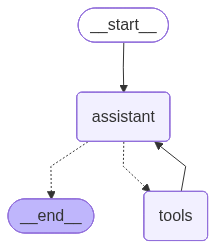

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Граф
builder = StateGraph(MessagesState)

# Опредеяем узлы (вершины): они выполняют действия
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Определяем рёбра (связи): они определяют как движется поток управления
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # Если последнее сообщение (результат) от assistant является вызовом инструмента -> tools_condition перенаправляет к tools
    # Если последнее сообщение (результат) от assistant не является вызовом инструмента -> tools_condition перенаправляет к END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Визуальное представление
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Память

Давайте запустим нашего агента, как и раньше.

In [5]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (qtRUZqFuO)
 Call ID: qtRUZqFuO
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


Теперь давайте умножим на 2!

In [6]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like I don't have a value to multiply by 2 yet. Could you provide the initial number or expression you'd like me to multiply by 2?


Мы не сохраняем в памяти число 7 из нашего первоначального диалога!

Это происходит потому, что [состояние является временным](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) в рамках одного выполнения графа.

Конечно, это ограничивает наши возможности для ведения многотуровых диалогов с перерывами.

Мы можем решить эту проблему с помощью [персистентности](https://docs.langchain.com/oss/python/langgraph/persistence)!

LangGraph может использовать механизм контрольных точек для автоматического сохранения состояния графа после каждого шага.

Этот встроенный слой персистентности даёт нам память, позволяя LangGraph продолжить работу с последнего обновления состояния.

Один из самых простых в использовании механизмов контрольных точек - это `MemorySaver`, хранилище "ключ-значение" в оперативной памяти для состояния графа.

Всё, что нам нужно сделать - это скомпилировать граф с механизмом контрольных точек, и наш граф получит память!

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

При использовании памяти нам нужно указать `thread_id`.

Этот `thread_id` будет хранить нашу коллекцию состояний графа.

Вот упрощённое объяснение:

* Механизм контрольных точек записывает состояние на каждом шаге графа
* Эти контрольные точки сохраняются в потоке (thread)
* Мы можем получить доступ к этому потоку в будущем, используя `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [8]:
# Добавляем id потока
config = {"configurable": {"thread_id": "1"}}

# Добавляем сообщение
messages = [HumanMessage(content="Add 3 and 4.")]

# Запускаем
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (qUI3fKlx2)
 Call ID: qUI3fKlx2
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


Если мы передадим тот же `thread_id`, то сможем продолжить с ранее сохранённой контрольной точки состояния!

В данном случае, приведённый выше диалог сохраняется в потоке.

Переданное нами `HumanMessage` (`"Multiply that by 2."`) добавляется к предыдущему диалогу.

Таким образом, модель теперь понимает, что `that` относится к `"The sum of 3 and 4 is 7."`.

In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (qUI3fKlx2)
 Call ID: qUI3fKlx2
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (82OWmhlR9)
 Call ID: 82OWmhlR9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multiplying 7 by 2 is **14**.


## Studio

**⚠️ Внимание**

После создания этих видео мы обновили Studio, и теперь её можно запускать локально и открывать в браузере. Это предпочтительный способ работы со Studio вместо использования Desktop App, показанного в видео. Теперь она называется _LangSmith Studio_ вместо _LangGraph Studio_. Подробные инструкции по настройке доступны в руководстве "Начало работы" в начале курса. Описание Studio можно найти [здесь](https://docs.langchain.com/langsmith/studio), а конкретные детали по локальному развертыванию — [здесь](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).

Чтобы запустить локальный сервер разработки, выполните следующую команду в терминале в директории `/studio` этого модуля:

```
langgraph dev
```

В ответ вы должны увидеть следующий вывод:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Откройте браузер и перейдите по адресу Studio UI, указанному выше.

Выберите `router` в Studio, который использует `module-1/studio/router.py`, указанный в `module-1/studio/langgraph.json`.